In [1]:
# Get necessary packages
import numpy as np
import pandas as pd
from scipy.io import *
from pylab import *
from pandas import DataFrame as df
from hmmlearn import hmm
# import random
from scipy import stats
from scipy.spatial import distance

In [2]:
#Retrieve FPP and community clusters
FPPs = loadmat('Matrix120.mat')['s'][0]
communitiest = loadmat('Cluster120.mat')['b'][0]
# mod = loadmat('structure_stats.mat')['c'][0]

In [3]:
def Markov_Clustering_Gauss(FPP, c):
    '''
    Get markov clusters for gamma only works for clusters with probabilities adding up to 1
    Input: theta cycles matrix, inflation parameter
    Output: labels for each FPP
    '''
    gm =hmm.GaussianHMM(c)
    #get parameters
    model =gm.fit(FPP, len(FPP))
    clusters = gm.predict(FPP)              # get clusters
    return clusters

In [4]:
def Markov_Clustering_Gmm(FPP, c):
    '''
    Get markov clusters for gamma
    Input: theta cycles matrix, inflation parameter
    Output: labels for each FPP
    '''
    gm =hmm.GMMHMM(c)
    # get parameters
    model =gm.fit(FPP, len(FPP))
    # get clusters
    clusters = gm.predict(FPP)
    return clusters

In [5]:
#  Get amount of clusters expected through community clustering
PFC_means=[]
for i in range(1,16, 2):
    PFC_means.append(np.mean(communitiest[i]))
PFC_k= round(np.mean(np.array(PFC_means)))
HPC_means=[]
for i in range(0,16,2):
    HPC_means.append(np.mean(communitiest[i]))
HPC_k=round(np.mean(np.array(HPC_means)))


In [6]:
# Retrieve HMM clustering labels
pfc_clusters=[]
for i in range(1,16,2):
    rat = FPPs[i]
    c = PFC_k
    pfc_clusters.append(Markov_Clustering_Gmm(rat, c))
hpc_clusters=[]
for i in range(0,16,2):
    rat = FPPs[i]
    c = HPC_k
    hpc_clusters.append(Markov_Clustering_Gmm(rat, c))
    

In [7]:
def recluster(FPP, clusters, start=0, step=2):
    '''
    Input: all FPPs, cluster labels from kmeans, start and step point rat iteration
    Export: all clusters for all rats
    Retrieve the data within the clusters
    '''
    pls = []
    for i in range(start,16,step):
        cl_ = []
        clust = dict()
        for j in range(0,len(np.array(clusters[i//2]))):
            clus=np.array(clusters[i//2])[j]
            cls_=[]
            F= FPP[i]
            cluster=F[j]
            if clus not in clust:
                clust[clus]=np.array([cluster])
            else:
                clust[clus]= np.append(clust[clus],[cluster], axis=0)
        pls.append([clust])
    return pls

In [8]:
pls_pfc = recluster(FPPs, pfc_clusters,1)
pls_hpc = recluster(FPPs, hpc_clusters)

In [20]:
def pearson_dist(x, y):
    r = stats.pearsonr(x, y)[0]
    return (1 - r) / 2

def pearsoncor(x, y):
    r = stats.pearsonr(x, y)[0]
    return r
def mahalobis(x, y, lr=False):
    m =list(zip(x, y))
    try:
        iv = np.linalg.inv(np.cov(m))
    except:
        iv = np.linalg.pinv(np.cov(m)) 
    return distance.mahalanobis(x, y,iv)
def lrratio(x):
    l=stats.norm.cdf(x)
    return 1-l
def intracor(clusters, FPP_k, pearsondist=False, mahalanobis=False):
    '''
    Retrieve correlations between the points in a specific cluster
    Input: Singular FPP, mean of all FPP within cluster, distance function indicator
    '''
    intra = []
    for j in range(20):
        FPP_i=clusters[:,j]
        if mahalanobis:
            intra.append(mahalobis(FPP_i, FPP_k))
        elif pearsondist:
            intra.append(pearson_dist(FPP_i, FPP_k))
        #Default pearson cor
        else:
            intra.append(pearsoncor(FPP_i, FPP_k))
    return intra

def extracor(FPP_i, FPP_k, pearsondist=False,lr=False, mahalanobis=False):
    '''
    Retrieve correlations between the points in a specific cluster and the other clusters
    Input: Singular FPP, mean of all FPP outside of clusters, distance function indicator
    '''
    extra=[]
    
    cluster = FPP_k.reshape(len(FPP_k),51, 20)
    cluster = np.mean(cluster, axis=0)
    FPP_k= np.mean(cluster, axis=1)
    for j in range(20):
        FPP_i=cluster[:,j]
        if mahalanobis or lr:
            extra.append(mahalobis(FPP_i, FPP_k))
        elif pearsondist:
            extra.append(pearson_dist(FPP_i, FPP_k))
        #Default pearson cor
        else:
            extra.append(pearsoncor(FPP_i, FPP_k))
    if lr:
        return np.nanmean(lrratio(extra))
    return np.nanmin(extra)

In [14]:
def gamma_sort(pls,num,region, threshold = 0.95):
    '''
    Input: clusters for all rats, number of clusters, region and threshold for centroid of gamma
    Output:mean (res/results) of all FPP in clusters for all rats, significancies for all distance measures  
    Sort into gamma clusters, retrieve significance and plot
    note: when num>1 iterate over ex_clusters
    '''
    res = []
    accuracy_ex=[]
    accuracy_in=[]
    M_accuracy_ex=[]
    M_accuracy_in=[]
    lr_accuracy =[]
    for j in range(len(pls)):
        print('Rat')
        cls_=pls[j][0]
        clusters=[]
        ex_clusters= cls_.copy()
        in_acc=[]
        ex_acc=[]
        lr_acc=[]
        M_ex_clusters= cls_.copy()
        M_in_acc=[]
        M_ex_acc=[]
        lr_ex_clusters= cls_.copy()
        for i in range(num):
            print('Cluster')
            cluster =np.array(cls_[i])

#             gamma_peak = threshold*max(np.array([np.max(c) for c in cluster]))
            cluster=cluster.reshape(len(cluster),51,20)
            masked_cluster=np.mean(cluster, axis=0)
            #Measure significance
            
            ex_clusters.pop(i)
            for c in list(ex_clusters.keys()):
                #Pearson
                intra = np.nanmean(intracor(masked_cluster, np.mean(masked_cluster, axis=1)))
                extra=extracor(masked_cluster, np.array(ex_clusters[c]))
                in_acc.append(intra)
                ex_acc.append(extra)
                ex_clusters=cls_.copy()
                #mahalanobis
                M_ex_clusters.pop(i)
                M_intra = np.nanmean(intracor(masked_cluster, np.mean(masked_cluster, axis=1), mahalanobis=True))
                M_extra=extracor(masked_cluster, np.array(M_ex_clusters[c]), mahalanobis=True)
                M_in_acc.append(M_intra)
                M_ex_acc.append(M_extra)
                M_ex_clusters=cls_.copy()
                #Lratio
                lr_ex_clusters.pop(i)
                lr=extracor(masked_cluster, np.array(lr_ex_clusters[c]),lr=True)
                lr_acc.append(lr)
                lr_ex_clusters=cls_.copy()

            
            imshow(masked_cluster,extent=[-np.pi, np.pi, 120, 20],aspect='auto', cmap = 'hot' )
            ylabel('Frequencies(Hz)')    
            xlabel('Phase')
            colorbar()
            if j>=4:
                title('Rat %i cluster %i %s'%(j+2,i+1, region))

                savefig('freq120/hmm/mean/HMM Rat %i cluster %i %s'%(j+2,i+1, region))
            else:
                title('Rat %i cluster %i %s'%(j+1,i+1, region))
                savefig('freq120/hmm/mean/HMM Rat %i cluster %i %s'%(j+1,i+1, region))
            show()
            #show average bin
#             for c in range(20):
#                 imshow(np.array([masked_cluster[:,c]]).T,aspect='auto' )
#                 ylabel('Frequencies(Hz)')
#                 colorbar()
#                 xlabel('Phase')
#                 if j>=4:
#                     title('Rat %i cluster %i cycle %i'%(j+2,i+1, c+1 ))

#     #                 savefig('Rat %i cluster %i %s cycle %i'%(j+2,i+1, region, c+1))
#                 else:
#                     title('Rat %i cluster %i cycle %i'%(j+1,i+1, c+1))
#     #                 savefig('Rat %i cluster %i %s cycle %i'%(j+1,i+1, region, c+1)
#                 show()
#             print(list(range(len(cluster))))
#             l=random.choices(list(range(len(cluster))), k=3)
#             for f in l:
#                 imshow(cluster[f],extent=[-np.pi, np.pi, 120, 20],aspect='auto' )
#                 ylabel('Frequencies(Hz)')
#                 colorbar()
#                 xlabel('Phase')
#                 if j>=4:
#                     title('Rat %i cluster %i random sample %s'%(j+2,c+1, region))

#                     savefig('HMM Rat %i cluster %i random sample %i'%(j+2,c+1, f+1))
#                 else:
#                     title('Rat %i cluster %i random sample %s'%(j+1,c+1, region))
#                     savefig('HMM Rat %i cluster %i random sample %i'%(j+1,c+1, f+1))
#                 show()
            
            clusters.append(masked_cluster)
        accuracy_ex.append(ex_acc)
        accuracy_in.append(in_acc)
        M_accuracy_ex.append(M_ex_acc)
        M_accuracy_in.append(M_in_acc)
        lr_accuracy.append(lr_acc)
        res.append(clusters)
    return res, accuracy_ex, accuracy_in, M_accuracy_ex,M_accuracy_in,lr_accuracy

Rat
Cluster


/home/denise/.local/lib/python3.8/site-packages/scipy/spatial/distance.py:1069: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


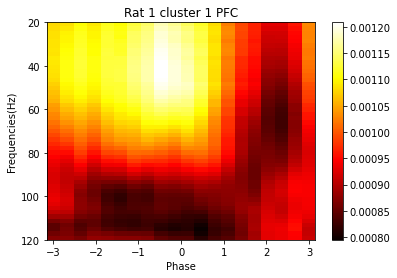

Cluster


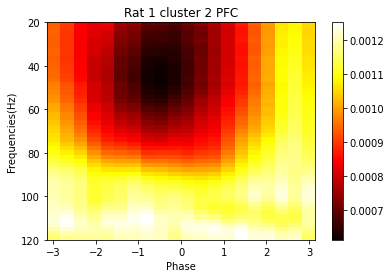

Rat
Cluster


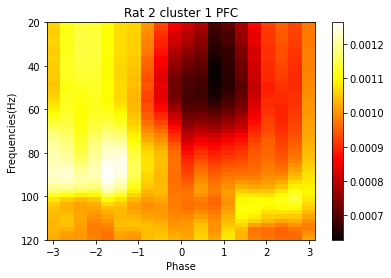

Cluster


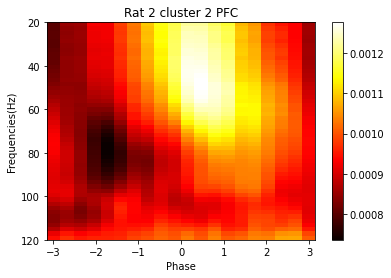

Rat
Cluster


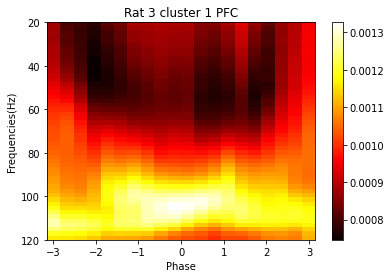

Cluster


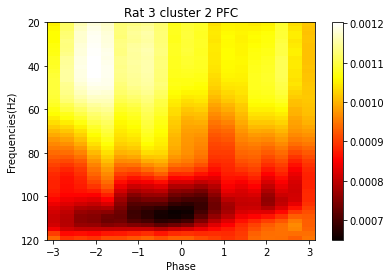

Rat
Cluster


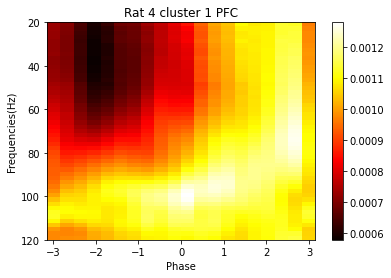

Cluster


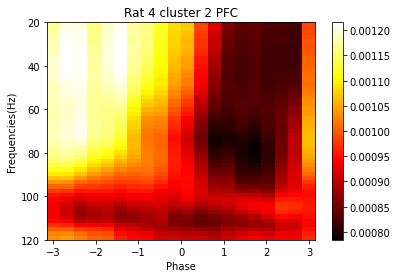

Rat
Cluster


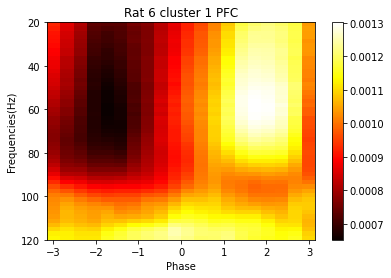

Cluster


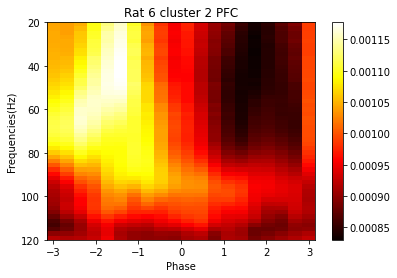

Rat
Cluster


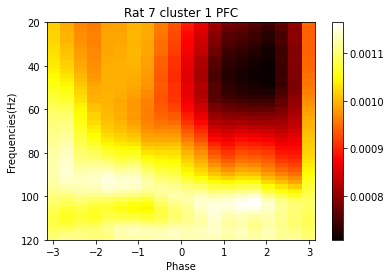

Cluster


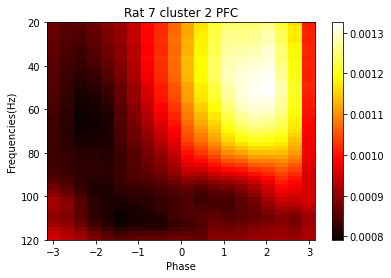

Rat
Cluster


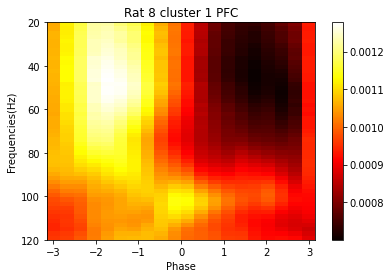

Cluster


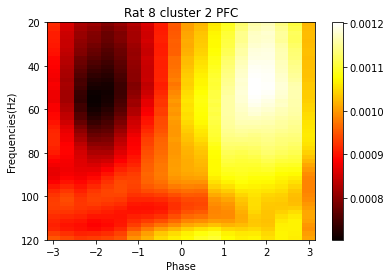

Rat
Cluster


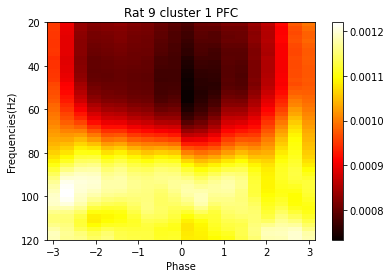

Cluster


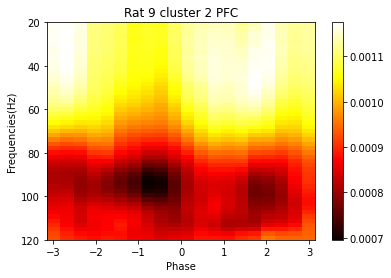

Rat
Cluster


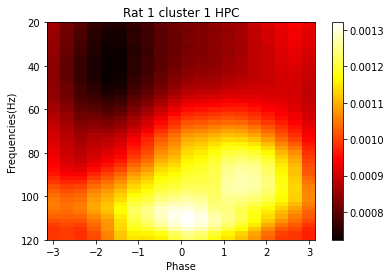

Cluster


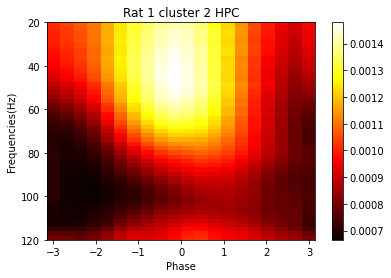

Rat
Cluster


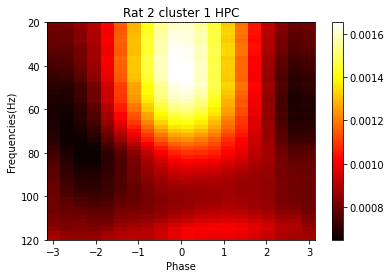

Cluster


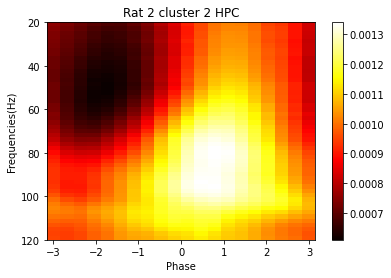

Rat
Cluster


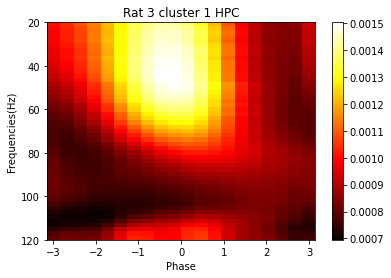

Cluster


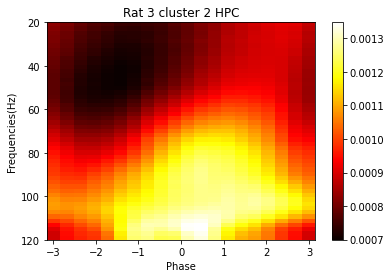

Rat
Cluster


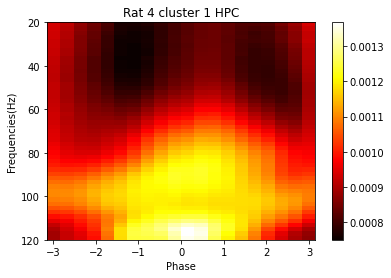

Cluster


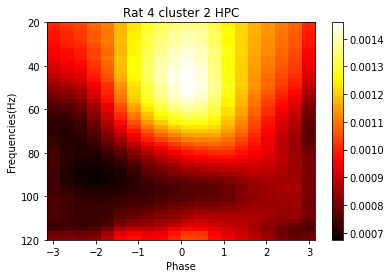

Rat
Cluster


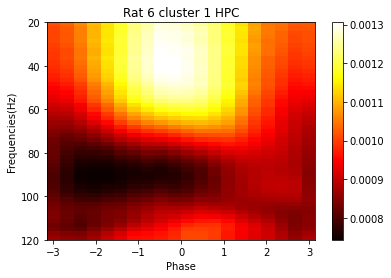

Cluster


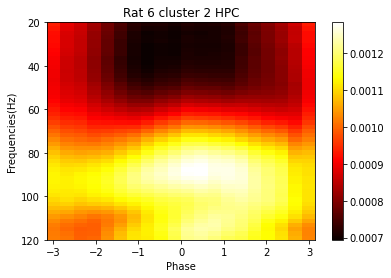

Rat
Cluster


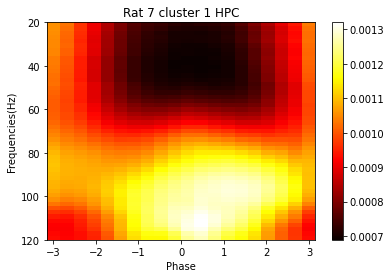

Cluster


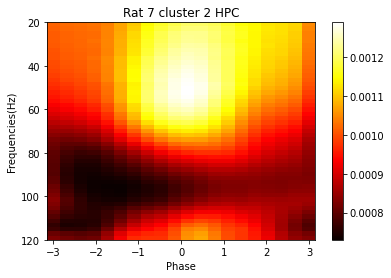

Rat
Cluster


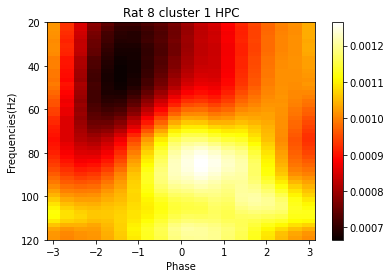

Cluster


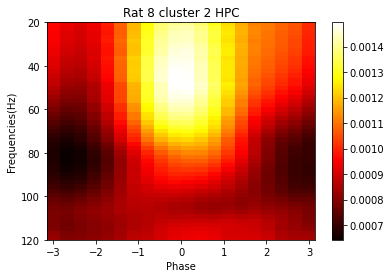

Rat
Cluster


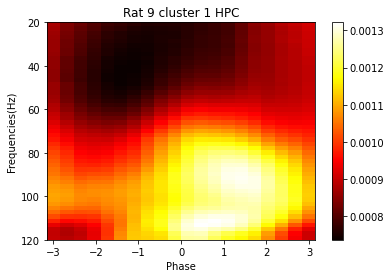

Cluster


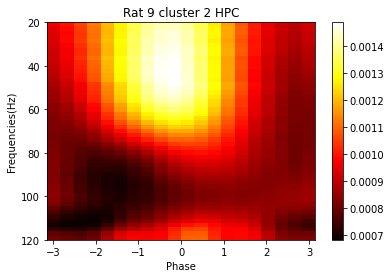

In [21]:
gamma_clusters_pfc,pfc_cluster_ex, pfc_cluster_in, mpfc_cluster_ex, mpfc_cluster_in,lr_pfc=gamma_sort(pls_pfc, 2, 'PFC')
gamma_clusters_hpc,hpc_cluster_ex,hpc_cluster_in, mhpc_cluster_ex, mhpc_cluster_in,lr_hpc=gamma_sort(pls_hpc, 2, 'HPC')

In [22]:
# Store all data in dataframe
df_clusters =  df(columns =['Rat', 'Cluster_Number','PFC_Clusters', 'HPC_Clusters', 'PFC_Gamma_Clusters', 'HPC_Gamma_Clusters'])
df_clusters['PFC_Clusters']= df_clusters['PFC_Clusters'].astype(object)
df_clusters['HPC_Clusters']= df_clusters['HPC_Clusters'].astype(object)
df_clusters['PFC_Gamma_Clusters']= df_clusters['PFC_Gamma_Clusters'].astype(object)
df_clusters['HPC_Gamma_Clusters']= df_clusters['HPC_Gamma_Clusters'].astype(object)
for i in range(0,8):
    j=i+1
    if j >= 5:
        j+=1
    for num in range(len(gamma_clusters_hpc[i])):
        hpc_extra = hpc_cluster_ex[i][num]
        hpc_intra =hpc_cluster_in[i][num]
        pfc_extra =pfc_cluster_ex[i][num]
        pfc_intra = pfc_cluster_in[i][num]
        m_hpc_extra = mhpc_cluster_ex[i][num]
        m_hpc_intra =mhpc_cluster_in[i][num]
        m_pfc_extra =mpfc_cluster_ex[i][num]
        m_pfc_intra = mpfc_cluster_in[i][num]
        lr_hpc_extra = lr_hpc[i][num]
        lr_pfc_extra =lr_pfc[i][num]
        df_clusters=df_clusters.append({'Rat':j,'Cluster_Number':num+1,'PearsonDistance_PFC_Intra_Cluster': pfc_intra,\
                                        'PearsonDistance_PFC_Inter_cluster':pfc_extra,'PearsonDistance_HPC_Intra_Cluster': hpc_intra, \
                                        'PearsonDistance_HPC_Inter_cluster':hpc_extra,'MahalanobisDistance_PFC_Intra_Cluster': m_pfc_intra,\
                                        'MahalanobisDistance_PFC_Inter_cluster':m_pfc_extra,'MahalanobisDistance_HPC_Intra_Cluster': m_hpc_intra, \
                                        'MahalanobisDistance_HPC_Inter_cluster':m_hpc_extra,'LRatio_PFC':lr_pfc_extra,'LRatio_HPC':lr_hpc_extra,'PFC_Clusters':pfc_clusters[i], 'HPC_Clusters': hpc_clusters[i], \
                                        'PFC_Gamma_Clusters':gamma_clusters_pfc[i][num], 'HPC_Gamma_Clusters':gamma_clusters_hpc[i][num]}, ignore_index=True)

/tmp/ipykernel_3496/2426325396.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_clusters=df_clusters.append({'Rat':j,'Cluster_Number':num+1,'PearsonDistance_PFC_Intra_Cluster': pfc_intra,\
/tmp/ipykernel_3496/2426325396.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_clusters=df_clusters.append({'Rat':j,'Cluster_Number':num+1,'PearsonDistance_PFC_Intra_Cluster': pfc_intra,\
/tmp/ipykernel_3496/2426325396.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_clusters=df_clusters.append({'Rat':j,'Cluster_Number':num+1,'PearsonDistance_PFC_Intra_Cluster': pfc_intra,\
/tmp/ipykernel_3496/2426325396.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. U

In [23]:
df_clusters.to_csv('freq120/hmm/mean/Clustershmm_120_2_min.csv',index=False)

In [22]:
df_clusters

,Rat,Cluster_Number,PFC_Clusters,HPC_Clusters,PFC_Gamma_Clusters,HPC_Gamma_Clusters,LRatio_HPC,LRatio_PFC,MahalanobisDistance_HPC_Inter_cluster,MahalanobisDistance_HPC_Intra_Cluster,MahalanobisDistance_PFC_Inter_cluster,MahalanobisDistance_PFC_Intra_Cluster,PearsonDistance_HPC_Inter_cluster,PearsonDistance_HPC_Intra_Cluster,PearsonDistance_PFC_Inter_cluster,PearsonDistance_PFC_Intra_Cluster
0,1,1,"[0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, ...","[1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, ...","[[0.0009330358123242683, 0.0009701761822253285...","[[0.001021581135896365, 0.00097851791944902, 0...",7.174232e-04,7.800413e-03,37.408982,7.141146,20.165836,11.635501,0.994993,0.854233,0.997387,0.962170
1,1,2,"[0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, ...","[1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, ...","[[0.0011287299859119402, 0.0010946814643273523...","[[0.0009835894291131506, 0.0009064317422705799...",8.473263e-07,2.143562e-02,9.651432,9.951696,89.885012,6.815633,0.978448,0.819824,0.996987,0.957793
2,2,1,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, ...","[[0.0009168190713802817, 0.0009594282524140984...","[[0.000912767647898844, 0.0008411890849283162,...",6.581259e-03,4.312336e-08,17.297763,6.706094,16.521602,7.214058,0.987023,0.762364,0.869045,0.374319
3,2,2,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, ...","[[0.0009080370292990978, 0.0009423747258577099...","[[0.0008572428277447, 0.0008447728757755676, 0...",5.075169e-03,2.979473e-03,20.006164,6.362709,18.310214,9.194352,0.991739,0.526919,0.933950,0.321925
4,3,1,"[1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, ...","[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, ...","[[0.0011475109448504698, 0.0011529986298863507...","[[0.001154609338682053, 0.0011568732810570252,...",1.395709e-02,2.780996e-03,19.720016,6.267059,18.173497,4.598772,0.989825,0.704753,0.991948,0.941618
5,3,2,"[1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, ...","[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, ...","[[0.0009142267638825669, 0.00087641627145148, ...","[[0.000914165682708441, 0.0008545093376105318,...",1.605620e-02,2.319153e-02,13.259530,5.886810,8.190160,6.956910,0.991363,0.916100,0.990646,0.951398
6,4,1,"[1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, ...","[0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, ...","[[0.0008893551487327521, 0.0008729053228074463...","[[0.0011287675458683665, 0.001090913041297548,...",3.209689e-02,2.332367e-02,19.812374,7.644026,11.054784,4.793163,0.976868,0.919383,0.966211,0.499183
7,4,2,"[1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, ...","[0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, ...","[[0.0010953113860721418, 0.0011347819024930508...","[[0.000952775304275269, 0.0009244833666610735,...",8.691520e-03,6.244410e-03,24.931623,6.147504,7.411968,5.714378,0.987186,0.876226,0.992310,0.220580
8,6,1,"[0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, ...","[1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, ...","[[0.0010247827422830422, 0.0010110024058196862...","[[0.0010367516008694003, 0.0010218326553058385...",6.518061e-03,1.293020e-02,25.297581,4.803680,10.695615,6.055456,0.996909,0.985234,0.987047,0.731072
9,6,2,"[0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, ...","[1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, ...","[[0.0009744037498982584, 0.0009288518135959941...","[[0.000911184732032807, 0.0008834963719476581,...",2.530612e-02,1.264181e-02,9.039713,8.953886,14.096831,6.219616,0.998514,0.984318,0.989307,0.644484
